In [2]:
# Importar bibliotecas
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import (
    HillClimbSearch, BicScore, K2Score, MaximumLikelihoodEstimator, BayesianEstimator
)
from pgmpy.inference import VariableElimination
import numpy as np


c:\Users\crish\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Carregar o dataset Titanic
# Se estiver usando o Google Colab, você pode carregar o arquivo 'train.csv' diretamente
# Aqui, vamos usar um link direto para o dataset
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'

# Carregar o dataset
data = pd.read_csv(url)


In [4]:
# Verificar as primeiras linhas do dataset
print("Primeiras linhas do dataset:")
print(data.head())

# Verificar valores ausentes
print("\nValores ausentes por coluna:")
print(data.isnull().sum())

# Preencher valores ausentes em 'Age' com a mediana
data['Age'].fillna(data['Age'].median(), inplace=True)

# Preencher valores ausentes em 'Embarked' com o valor mais frequente
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

# Excluir a coluna 'Cabin' devido ao grande número de valores ausentes
data.drop(columns=['Cabin'], inplace=True)

# Converter 'Sex' para valores numéricos
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

# Converter 'Embarked' para valores numéricos
data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Selecionar as colunas relevantes
data = data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

# Discretizar 'Age' e 'Fare'
data['Age'] = pd.cut(data['Age'], bins=[0, 12, 18, 35, 60, 80], labels=[0, 1, 2, 3, 4])
data['Fare'] = pd.qcut(data['Fare'], 4, labels=[0, 1, 2, 3])

# Converter todas as colunas para inteiro
data = data.astype(int)

# Verificar os dados após o pré-processamento
print("\nDados após o pré-processamento:")
print(data.head())


Primeiras linhas do dataset:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450

In [5]:
print("\nEstatísticas descritivas do dataset:\n")
print(data.describe())



Estatísticas descritivas do dataset:

         Survived      Pclass         Sex         Age       SibSp       Parch  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.383838    2.308642    0.352413    2.034792    0.523008    0.381594   
std      0.486592    0.836071    0.477990    0.839958    1.102743    0.806057   
min      0.000000    1.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    2.000000    0.000000    2.000000    0.000000    0.000000   
50%      0.000000    3.000000    0.000000    2.000000    0.000000    0.000000   
75%      1.000000    3.000000    1.000000    2.000000    1.000000    0.000000   
max      1.000000    3.000000    1.000000    4.000000    8.000000    6.000000   

             Fare    Embarked  
count  891.000000  891.000000  
mean     1.497194    0.361392  
std      1.118156    0.635673  
min      0.000000    0.000000  
25%      0.500000    0.000000  
50%      1.000000    0.000000  
75%    

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


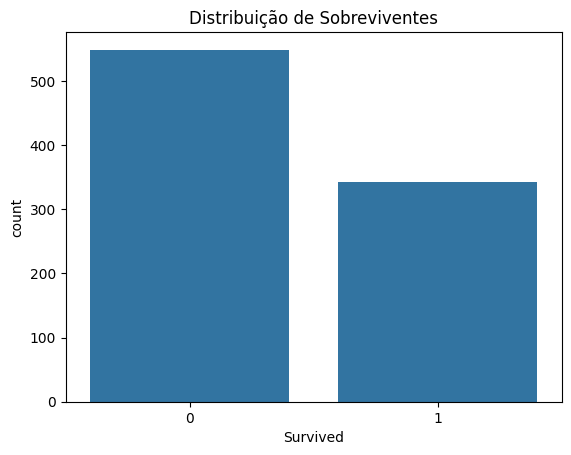

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


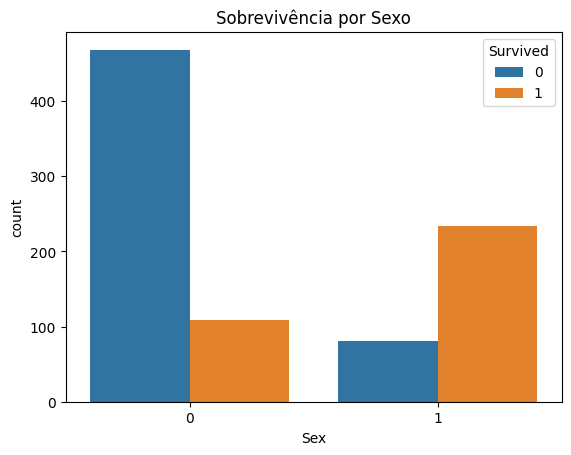

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


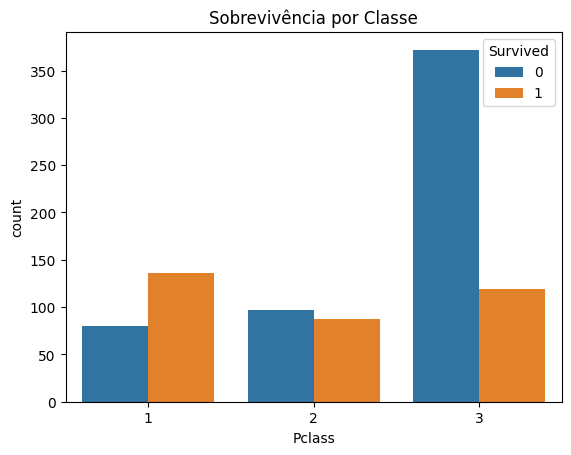

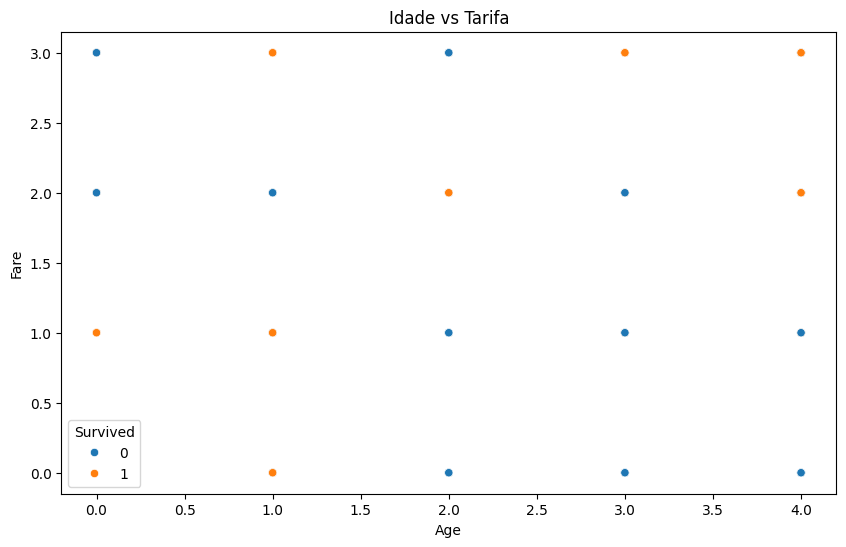

In [6]:
# Gráfico de contagem de sobreviventes
sns.countplot(x='Survived', data=data)
plt.title('Distribuição de Sobreviventes')
plt.show()

# Gráfico de sobrevivência por sexo
sns.countplot(x='Sex', hue='Survived', data=data)
plt.title('Sobrevivência por Sexo')
plt.show()

# Gráfico de sobrevivência por classe
sns.countplot(x='Pclass', hue='Survived', data=data)
plt.title('Sobrevivência por Classe')
plt.show()

# Gráfico de dispersão para 'Age' vs 'Fare'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=data)
plt.title('Idade vs Tarifa')
plt.show()


In [7]:
# Separar a variável alvo (Survived) das variáveis preditoras
X = data.drop('Survived', axis=1)
y = data['Survived']

# Dividir os dados em treinamento e teste
train_data, test_data = train_test_split(
    data, test_size=0.2, random_state=42, stratify=data['Survived']
)

print(f"\nConjunto de Treinamento: {len(train_data)} registros")
print(f"Conjunto de Teste: {len(test_data)} registros")



Conjunto de Treinamento: 712 registros
Conjunto de Teste: 179 registros


In [8]:
# Usando Hill Climbing e BIC Score
est_hc = HillClimbSearch(train_data)
best_model_bic = est_hc.estimate(scoring_method=BicScore(train_data))

# Usando Hill Climbing e K2 Score
k2score = K2Score(train_data)
best_model_k2 = est_hc.estimate(scoring_method=k2score)


  0%|          | 27/1000000 [00:00<4:08:47, 66.99it/s]


In [14]:
# Modelo com BIC Score
model_bic = BayesianNetwork(best_model_bic.edges())
model_bic.fit(train_data, estimator=BayesianEstimator, prior_type='BDeu')

# Modelo com K2 Score
model_k2 = BayesianNetwork(best_model_k2.edges())
model_k2.fit(train_data, estimator=BayesianEstimator, prior_type='BDeu')


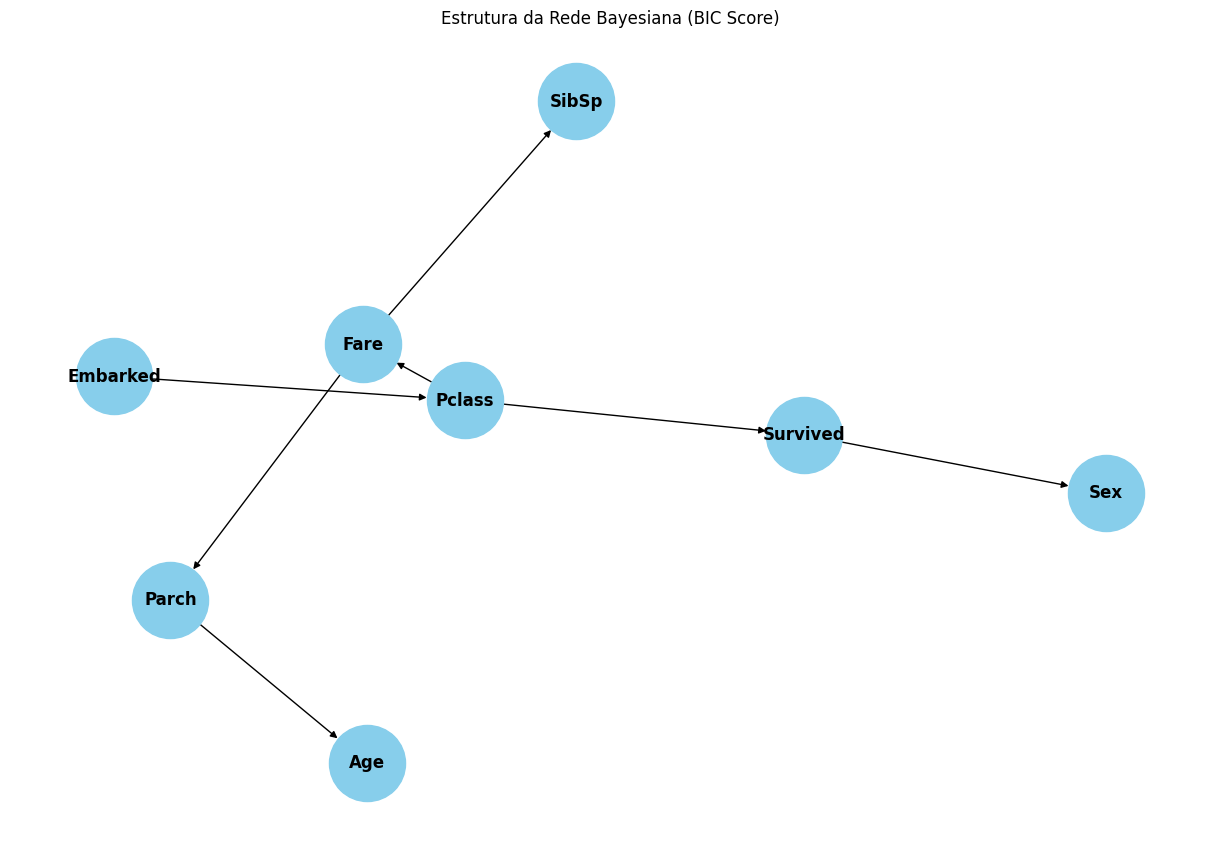

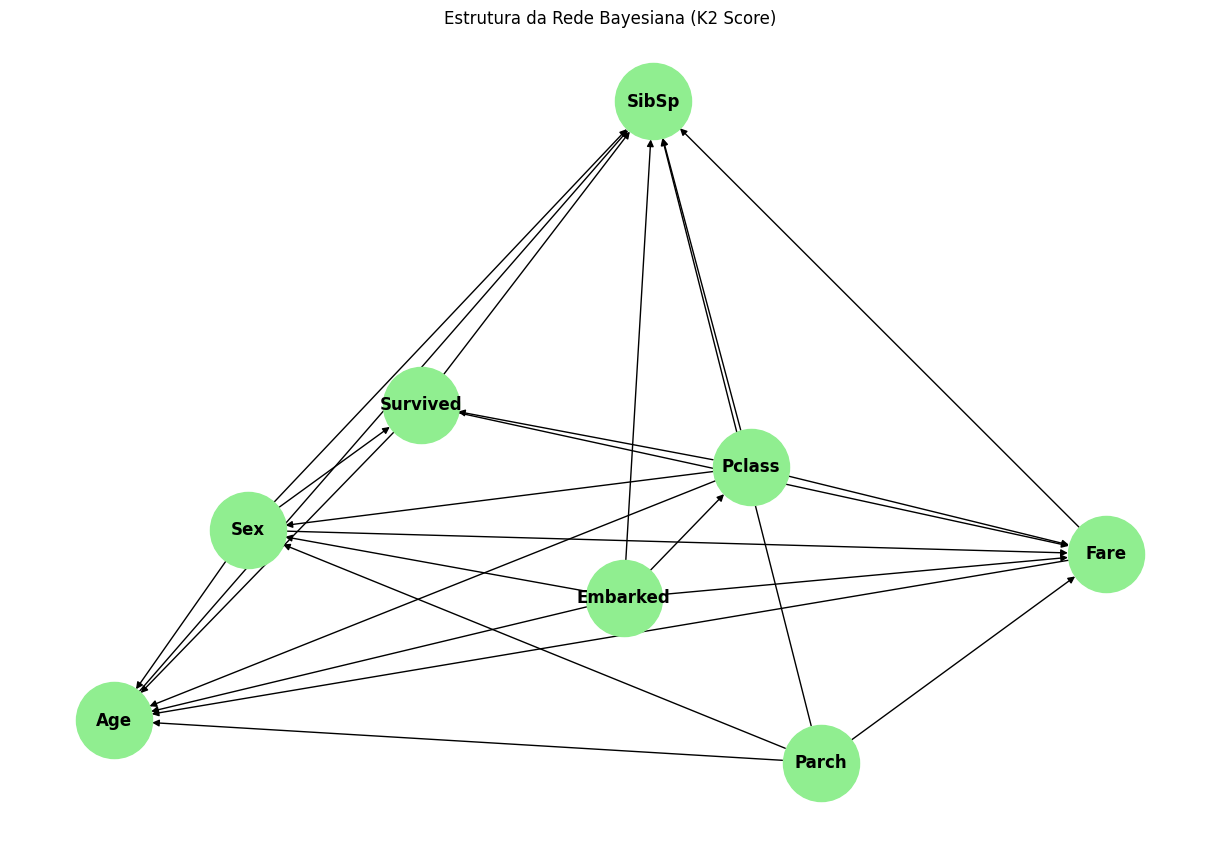

In [15]:
# Estrutura com BIC Score
plt.figure(figsize=(12, 8))
G_bic = nx.DiGraph(model_bic.edges())
pos_bic = nx.spring_layout(G_bic, seed=42)
nx.draw(G_bic, pos_bic, with_labels=True, node_size=3000, node_color="skyblue",
        font_size=12, font_weight="bold", arrows=True)
plt.title("Estrutura da Rede Bayesiana (BIC Score)")
plt.show()

# Estrutura com K2 Score
plt.figure(figsize=(12, 8))
G_k2 = nx.DiGraph(model_k2.edges())
pos_k2 = nx.spring_layout(G_k2, seed=42)
nx.draw(G_k2, pos_k2, with_labels=True, node_size=3000, node_color="lightgreen",
        font_size=12, font_weight="bold", arrows=True)
plt.title("Estrutura da Rede Bayesiana (K2 Score)")
plt.show()


In [16]:
# Criar o objeto de inferência para o modelo BIC
infer_bic = VariableElimination(model_bic)

# Definir evidências (por exemplo, mulher de 1ª classe, idade entre 18 e 35 anos)
evidence = {'Sex': 1, 'Pclass': 1, 'Age': 2}

# Realizar a inferência para a variável 'Survived'
query_result_bic = infer_bic.query(variables=['Survived'], evidence=evidence)

# Imprimir o resultado
print("\nResultado da Inferência (Modelo BIC):")
print(query_result_bic)



Resultado da Inferência (Modelo BIC):
+-------------+-----------------+
| Survived    |   phi(Survived) |
+=============+=================+
| Survived(0) |          0.1062 |
+-------------+-----------------+
| Survived(1) |          0.8938 |
+-------------+-----------------+


In [17]:
def predict(model, data, evidence_vars, target_var='Survived'):
    inference = VariableElimination(model)
    predictions = []
    for idx, row in data.iterrows():
        evidence = {var: row[var] for var in evidence_vars}
        try:
            query_result = inference.query(variables=[target_var], evidence=evidence)
            prob = query_result.values
            predicted_state = np.argmax(prob)
            predictions.append(int(predicted_state))
        except Exception as e:
            #print(f'Erro no índice {idx}: {e}')
            predictions.append(0)  # Valor padrão em caso de erro
    return predictions

# Definir as variáveis de evidência
evidence_vars = data.columns.tolist()
evidence_vars.remove('Survived')

# Avaliar o modelo BIC
predictions_bic = predict(model_bic, test_data, evidence_vars)
accuracy_bic = accuracy_score(test_data['Survived'], predictions_bic)
print(f"\nAcurácia do Modelo BIC no Conjunto de Teste: {accuracy_bic:.4f}")
print("\nRelatório de Classificação (Modelo BIC):")
print(classification_report(test_data['Survived'], predictions_bic))

# Avaliar o modelo K2
predictions_k2 = predict(model_k2, test_data, evidence_vars)
accuracy_k2 = accuracy_score(test_data['Survived'], predictions_k2)
print(f"\nAcurácia do Modelo K2 no Conjunto de Teste: {accuracy_k2:.4f}")
print("\nRelatório de Classificação (Modelo K2):")
print(classification_report(test_data['Survived'], predictions_k2))



Acurácia do Modelo BIC no Conjunto de Teste: 0.7765

Relatório de Classificação (Modelo BIC):
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       110
           1       0.74      0.65      0.69        69

    accuracy                           0.78       179
   macro avg       0.77      0.75      0.76       179
weighted avg       0.77      0.78      0.77       179


Acurácia do Modelo K2 no Conjunto de Teste: 0.7095

Relatório de Classificação (Modelo K2):
              precision    recall  f1-score   support

           0       0.74      0.81      0.77       110
           1       0.64      0.55      0.59        69

    accuracy                           0.71       179
   macro avg       0.69      0.68      0.68       179
weighted avg       0.70      0.71      0.70       179



In [18]:
print("=== Discussão dos Resultados ===\n")

print(f"A acurácia do Modelo BIC é {accuracy_bic:.2f}")
print(f"A acurácia do Modelo K2 é {accuracy_k2:.2f}")

print("""
Analisando os relatórios de classificação, podemos observar:

- **Precisão**: Proporção de predições positivas corretas.
- **Recall**: Proporção de positivos reais que foram corretamente identificados.
- **F1-Score**: Média harmônica entre precisão e recall.

Os modelos apresentam desempenho que pode ser comparado com outros modelos mais simples ou complexos.

Possíveis ações para melhorar os modelos:

- **Incluir mais variáveis**: Considerar outras características presentes no dataset.
- **Ajustar a discretização**: Experimentar diferentes formas de discretizar variáveis contínuas.
- **Experimentar outros algoritmos**: Como o PC Algorithm ou métodos híbridos.
""")


=== Discussão dos Resultados ===

A acurácia do Modelo BIC é 0.78
A acurácia do Modelo K2 é 0.71

Analisando os relatórios de classificação, podemos observar:

- **Precisão**: Proporção de predições positivas corretas.
- **Recall**: Proporção de positivos reais que foram corretamente identificados.
- **F1-Score**: Média harmônica entre precisão e recall.

Os modelos apresentam desempenho que pode ser comparado com outros modelos mais simples ou complexos.

Possíveis ações para melhorar os modelos:

- **Incluir mais variáveis**: Considerar outras características presentes no dataset.
- **Ajustar a discretização**: Experimentar diferentes formas de discretizar variáveis contínuas.
- **Experimentar outros algoritmos**: Como o PC Algorithm ou métodos híbridos.

